In [1]:
# Sample API
import flowx
import simulation
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 100, 50
xmin, xmax = -3.0, 7.0
ymin, ymax = -2.5, 2.5

Re   = 100.0
dt   = 1e-3
tmax = 20.

ibm_x = 0.0
ibm_y = 0.0
ibm_r = 0.5

# Define cell-centered variable names
center_vars = ['pres', 'divv']
face_vars   = ['velc', 'hvar']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'outflow', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [1.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'neumann', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

scalars = flowx.Scalars(tmax=10.0, dt=0.01, Re=100.0)

In [3]:
simulation.set_initial_velocity(gridc, gridx, gridy, 'velc', 'pres')

------------ Time = 0.0 ---------------
Number of poisson iterations    : 1
Final poisson residual : 0.0
Max, Min, U   : 1.0, -1.0
Max, Min, V   : 0.0, 0.0
Max, Min, P   : 0.0, 0.0
Max, Min, DIV : 0.0, 0.0




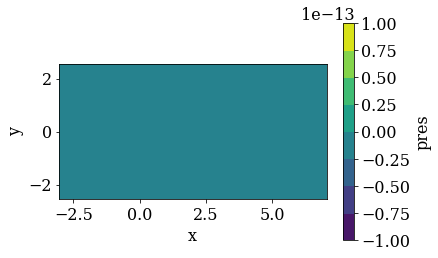

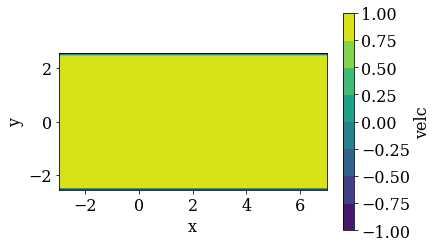

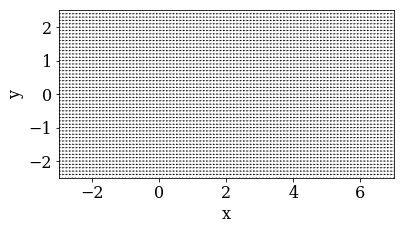

------------ Time = 0.09999999999999999 ---------------
Number of poisson iterations    : 5000
Final poisson residual : 3.95857926671995e-07
Max, Min, U   : 1.0368819713868438, -1.0
Max, Min, V   : 0.0941187271057464, -0.09411872710574644
Max, Min, P   : 0.6311402674396774, -0.6755331626686434
Max, Min, DIV : 2.2055202901771764e-06, -2.2282406936247057e-06


------------ Time = 0.20000000000000004 ---------------
Number of poisson iterations    : 5000
Final poisson residual : 2.637447963821191e-07
Max, Min, U   : 1.0637922745238657, -1.0
Max, Min, V   : 0.16777677654353002, -0.16777677654353004
Max, Min, P   : 0.5737249617181359, -0.6430213174172379
Max, Min, DIV : 1.4669631483166246e-06, -1.4870492466567686e-06


------------ Time = 0.3000000000000001 ---------------
Number of poisson iterations    : 5000
Final poisson residual : 2.001232193365068e-07
Max, Min, U   : 1.0788094539019404, -1.0
Max, Min, V   : 0.21733847231160489, -0.21733847231160497
Max, Min, P   : 0.5350629221537193, 

KeyboardInterrupt: 

In [4]:
ins_vars = ['velc', 'hvar', 'divv', 'pres']

while scalars.var['time'] <= scalars.var['tmax']:
    
    # Compute mass in the domain
    Qin = (simulation.get_qin(gridx, 'velc', bc_type_u['velc']) +
           simulation.get_qin(gridy, 'velc', bc_type_v['velc']))
    
    # Update the outflow boundary velocity using a convective equation.
    simulation.update_outflow_bc(gridx, 'velc', dt)
    
    # Predictor Step
    flowx.ins.euler(gridc, gridx, gridy, scalars, ins_vars, 'predictor')

    # Compute mass out of the domain
    Qout = (simulation.get_qout(gridx, 'velc', bc_type_u['velc']) +
            simulation.get_qout(gridy, 'velc', bc_type_v['velc']))
    
    # Rescale velocity at outflow and update BC
    simulation.rescale_velocity(gridx, 'velc', bc_type_u['velc'],
                                Qin, Qout) 
    simulation.update_outflow_bc(gridx, 'velc', dt, convvel=0.0)
    
    # Solve the pressure Poisson equation 
    ites, res = flowx.poisson.solve_jacobi(gridc, 'pres', 'divv',
                                         maxiter=5000, tol=1e-9)
    scalars.stats['ites'], scalars.stats['res'] = ites, res
    
    # Corrector Step
    flowx.ins.euler(gridc, gridx, gridy, scalars, ins_vars, 'corrector')
    
    # Display stats
    if scalars.var['nstep'] % 10 == 0:
        flowx.io.display_stats(scalars.var['time'], scalars.stats)  
        
    if scalars.var['nstep'] % 100 == 0:
        flowx.io.plot_contour(gridc, 'pres')
        flowx.io.plot_contour(gridx, 'velc')
        flowx.io.plot_vector(gridx,gridy,'velc')
              
    scalars.advance()

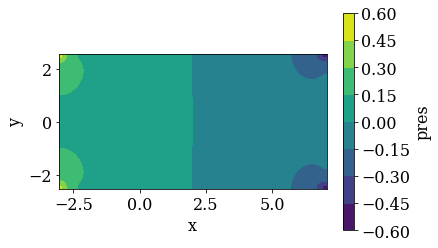

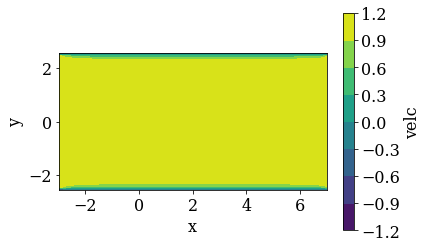

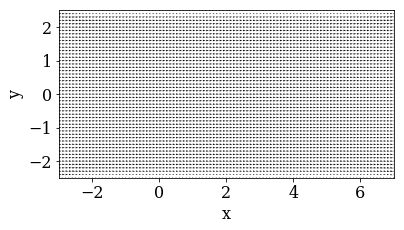

In [5]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_vector(gridx,gridy,'velc')